This first action just creates a file containing all the packages needed to run this notebook, run it first to make the notebook work, then we'll get going.

In [1]:
%%writefile requirements.txt
PyMuPDF == 1.24.9
matplotlib == 3.9.2
pandas == 2.2.2
numpy==1.26.4

Overwriting requirements.txt


First off, pip install the packages we want to use, note that this is done in python 3.12


In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Now we can get going, lets import our packages to use

In [3]:
import fitz  # This is MuPyPDF It's just called fitz I can't remember why and I think the reason is stupid anyway?
import re
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
from IPython.display import Image

Now we're going to try to grab the PDF data and clean it

In [16]:
def extract_lap_times_from_pdf(pdf_path, drivers_list):
    # Initialize a dictionary to store the drivers' lap times
    driver_lap_times = {driver: [] for driver in drivers_list}
    
    # Define a pattern to detect lap numbers and lap times, including pit stops
    pattern = re.compile(r'(\d+)\s+(\d{1,2}:\d{2}:\d{2}|\d{1,2}:\d{2}\.\d{3}|P)')

    # Extract text from the PDF using PyMuPDF/Fitz
    pdf_document = fitz.open(pdf_path)
    
    # Initialize variables
    text = ""
    
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text += page.get_text()  
    
    pdf_document.close()
    
    # Process the entire text to find driver sections and lap times
    text = text.strip()
    
    # Initialize a dictionary to track lap numbers already added for each driver
    driver_processed_laps = {driver: set() for driver in drivers_list}
    
    for driver in drivers_list:
        # Find the start index of the driver section
        start_index = text.find(driver)
        if start_index == -1:
            continue
        
        # Find the end index of the driver section
        end_index = len(text)
        for next_driver in drivers_list:
            if next_driver != driver:
                next_start_index = text.find(next_driver, start_index + len(driver))
                if next_start_index != -1 and next_start_index < end_index:
                    end_index = next_start_index
        
        # Extract driver section text
        driver_text = text[start_index:end_index]
        
        # Process the driver section text
        for match in pattern.finditer(driver_text):
            lap_number, lap_time = match.groups()
            
            if lap_time == 'P':
                # Modify the lap number for pit stop, but retain the original lap time from previous match
                modified_lap_number = f"{lap_number} (P)"
                
                # Extract the original lap time for this pit stop lap from the driver_text
                lap_time_match = pattern.search(driver_text[:match.start()])
                if lap_time_match:
                    _, lap_time = lap_time_match.groups()  # Extract the actual lap time
            else:
                modified_lap_number = lap_number

            # Add lap time to the current driver
            if modified_lap_number not in driver_processed_laps[driver]:
                driver_processed_laps[driver].add(modified_lap_number)
                driver_lap_times[driver].append({modified_lap_number: lap_time})
        
    return driver_lap_times

# Define your list of drivers
drivers_list = [
    "Max VERSTAPPEN", "Daniel RICCIARDO", "Lando NORRIS", 
    "Sebastian VETTEL", "Nicholas LATIFI", "Pierre GASLY", 
    "Sergio PEREZ", "Fernando ALONSO", "Charles LECLERC", 
    "Lance STROLL", "Kevin MAGNUSSEN", "Yuki TSUNODA", 
    "Alexander ALBON", "ZHOU Guanyu", "Esteban OCON",
    "Lewis HAMILTON", "Mick SCHUMACHER", "Carlos SAINZ",
    "George RUSSELL", "Valtteri BOTTAS"
]

# Path to your PDF of laptimes
pdf_path = "Lap Analysis - SIN.pdf"

# Extract lap times
driver_lap_times = extract_lap_times_from_pdf(pdf_path, drivers_list)

# Print the lap times for each driver if you want to have a look at them and make sure it's worked!
for driver, laps in driver_lap_times.items():
    formatted_laps = ', '.join(f"{{'{lap_number}': '{lap_time}'}}" for lap in laps for lap_number, lap_time in lap.items())
    print(f"{driver}: [{formatted_laps}]")
    
#Save this all to a CSV so you can do STUFF with it later?

def write_lap_times_to_csv(driver_lap_times, csv_path):
    # Create a dictionary to organize lap times by lap number
    lap_times_by_number = {}
    
    for driver, laps in driver_lap_times.items():
        for lap in laps:
            for lap_number, lap_time in lap.items():
                if lap_number not in lap_times_by_number:
                    lap_times_by_number[lap_number] = {}
                lap_times_by_number[lap_number][driver] = lap_time

    # Get the sorted list of lap numbers
    lap_numbers = sorted(lap_times_by_number.keys(), key=lambda x: int(x.split()[0]))

    # Open the CSV file for writing
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = ['Lap Number'] + list(driver_lap_times.keys())
        writer.writerow(header)
        
        # Write lap times for each lap number
        for lap_number in lap_numbers:
            row = [lap_number]
            for driver in driver_lap_times.keys():
                row.append(lap_times_by_number.get(lap_number, {}).get(driver, ''))
            writer.writerow(row)

# Example usage:
csv_path = "lap_times.csv"
write_lap_times_to_csv(driver_lap_times, csv_path)

Max VERSTAPPEN: [{'1': '21:11:14'}, {'2': '2:04.389'}, {'3': '2:03.369'}, {'4': '2:03.238'}, {'5': '2:02.703'}, {'6': '2:03.027'}, {'7': '2:03.289'}, {'8': '2:23.240'}, {'9': '2:42.690'}, {'10': '2:38.596'}, {'11': '2:01.612'}, {'12': '2:00.967'}, {'13': '2:01.842'}, {'14': '2:01.558'}, {'15': '2:01.407'}, {'16': '2:01.138'}, {'17': '2:00.909'}, {'18': '2:00.807'}, {'19': '2:00.520'}, {'20': '2:00.559'}, {'21': '2:09.641'}, {'22': '2:35.288'}, {'23': '1:58.377'}, {'24': '1:58.784'}, {'25': '1:59.689'}, {'26': '2:22.695'}, {'27': '2:00.464'}, {'28': '2:13.500'}, {'29': '2:40.814'}, {'30': '2:08.953'}, {'31': '1:59.035'}, {'32': '1:58.925'}, {'33': '1:59.987'}, {'34': '1:59.730'}, {'35 (P)': '21:11:14'}, {'36': '2:55.179'}, {'37': '2:37.134'}, {'38': '2:47.754'}, {'39': '2:28.080'}, {'40 (P)': '21:11:14'}, {'41': '2:18.778'}, {'42': '1:53.170'}, {'43': '1:51.370'}, {'44': '1:50.616'}, {'45': '1:50.049'}, {'46': '1:51.824'}, {'47': '1:51.455'}, {'48': '1:50.508'}, {'49': '1:49.944'}, {'50

Now we've got our lap time data, lets do some Visualisations Of It

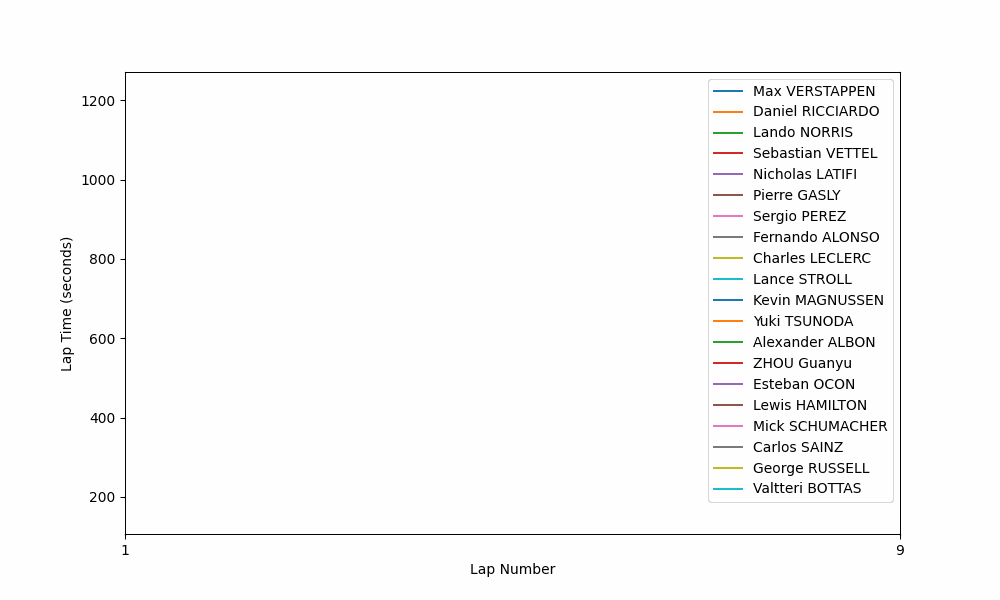

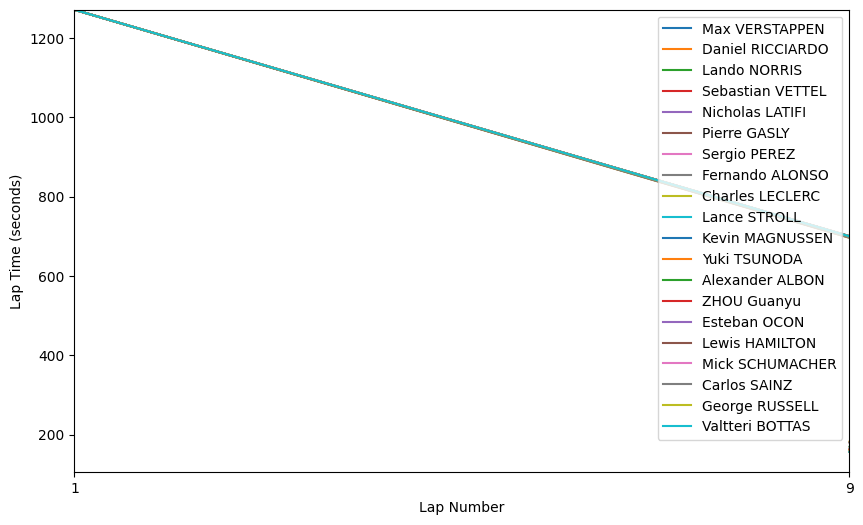

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv("lap_times.csv")

def convert_time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '':
        return np.nan
    if 'P' in time_str:
        return np.nan

    # Split by colon
    parts = time_str.split(':')
    
    # Handle different formats
    if len(parts) == 2:
        # Format: MM:SS or M:SS
        minutes = int(parts[0])
        seconds = parts[1]
    elif len(parts) == 3:
        # Format: MM:SS:MS or M:SS:MS
        minutes = int(parts[0])
        seconds = parts[1]
        milliseconds = parts[2]
    else:
        return np.nan  # Unexpected format
    
    if '.' in seconds:
        # Handle milliseconds
        seconds, milliseconds = seconds.split('.')
        return minutes * 60 + int(seconds) + int(milliseconds) / 1000
    else:
        return minutes * 60 + int(seconds)

# Apply the conversion to all time columns
for col in df.columns[1:]:
    df[col] = df[col].apply(convert_time_to_seconds)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize line plots for each driver
lines = {driver: ax.plot([], [], label=driver)[0] for driver in df.columns[1:]}

# Set axis labels and limits
ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (seconds)')
ax.set_xlim(df['Lap Number'].min(), df['Lap Number'].max())
ax.set_ylim(df.iloc[:, 1:].min().min(), df.iloc[:, 1:].max().max())
ax.legend(loc='upper right')

# Initialization function for the animation
def init():
    for line in lines.values():
        line.set_data([], [])
    return lines.values()

# Update function for the animation
def update(frame):
    for driver, line in lines.items():
        x_data = df['Lap Number'][:frame+1]
        y_data = df[driver][:frame+1]
        line.set_data(x_data, y_data)
    return lines.values()

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(df), init_func=init, blit=True, interval=500)

#Lets see it as a GIF because why not?
ani.save('animation.gif', writer='pillow', fps=15)
Image(filename='animation.gif')
